In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


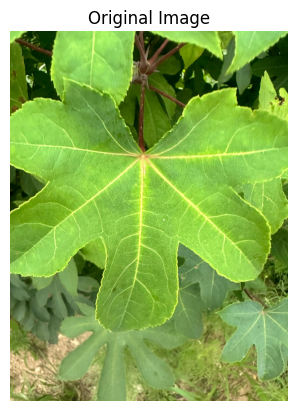

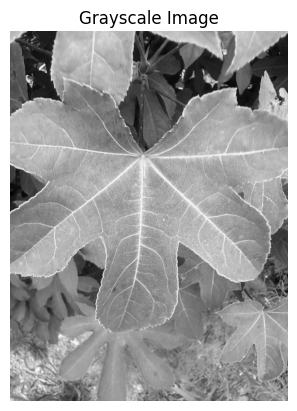

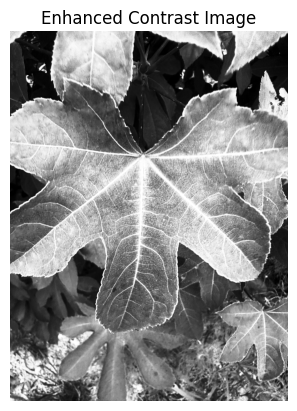

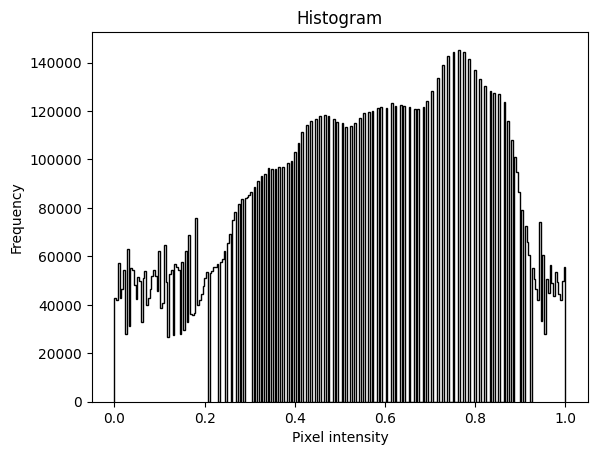

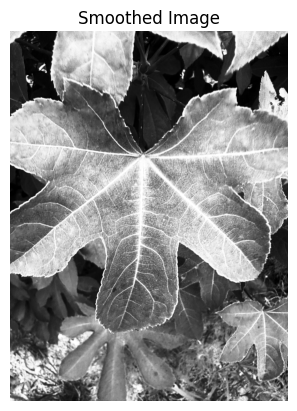

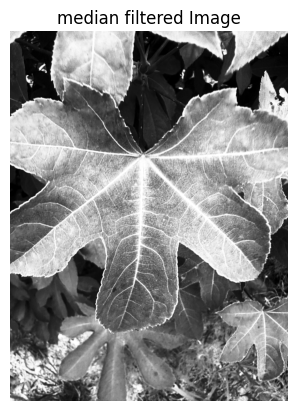

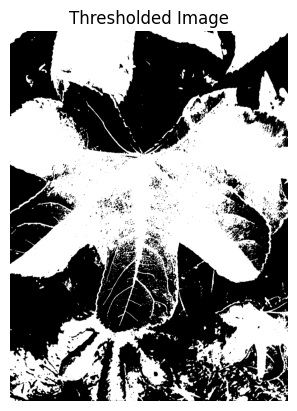

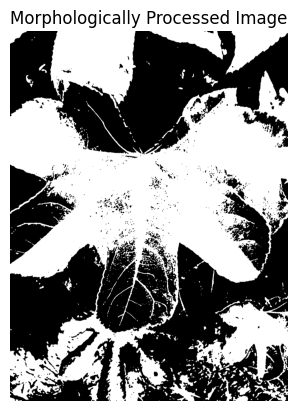

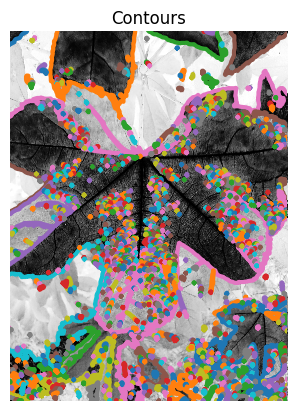

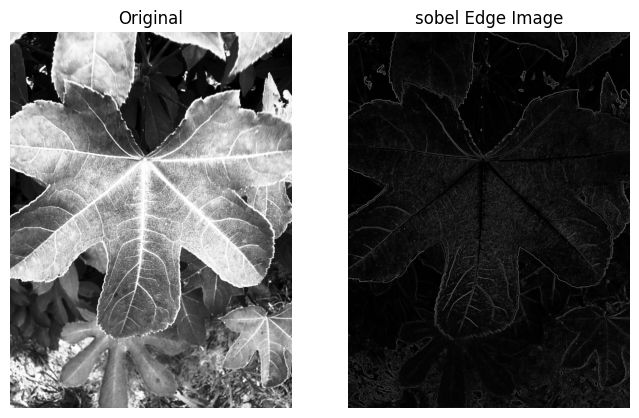

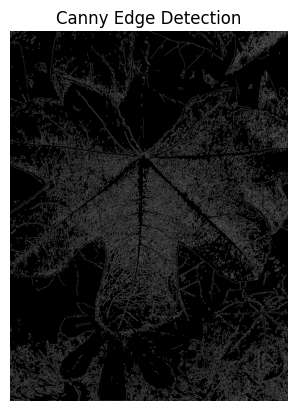

Number of Contours: 1569
Number of Edges (Canny): 271513.57355592557
The leaf is likely healthy.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from skimage import color, exposure, filters, measure
from skimage.filters import threshold_otsu, sobel, gaussian,threshold_isodata
from skimage.feature import canny
import cv2

# Function to display the image
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to plot comparisons
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 6), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')
    plt.show()

# Function to show image contours
def show_image_contour(image, contours):
    plt.figure()
    for n, contour in enumerate(contours):
        plt.plot(contour[:, 1], contour[:, 0], linewidth=3)
    plt.imshow(image, interpolation='nearest', cmap='gray_r')
    plt.title('Contours')
    plt.axis('off')
    plt.show()

def plot_histogram(image):
    plt.figure()
    plt.hist(image.ravel(), bins=256, histtype='step', color='black')
    plt.title('Histogram')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
    plt.show()

# Function to detect if a leaf is affected
def detect_leaf_affection(image_path):
    # Load the leaf image
    leaf_img = cv2.imread(image_path)
    if leaf_img is None:
        print("Error: Unable to load image. Please check the image path.")
        return

    # Convert to RGB for consistency with matplotlib
    leaf_img_rgb = cv2.cvtColor(leaf_img, cv2.COLOR_BGR2RGB)
    show_image(leaf_img_rgb, 'Original Image')

    # Convert the image to grayscale
    grayim = cv2.cvtColor(leaf_img, cv2.COLOR_BGR2GRAY)
    show_image(grayim, 'Grayscale Image')

    #Normalize the grayscale image
    grayimg = grayim/255.0

    #Enhancement contrast using histogram equalization
    enhanced_img = exposure.equalize_hist(grayimg)
    show_image(enhanced_img, 'Enhanced Contrast Image')
    plot_histogram(enhanced_img)

    #Apply  Gaussian smoothing
    smoothed_img = gaussian(enhanced_img, sigma=1)
    show_image(smoothed_img, 'Smoothed Image')

    smoothed_img = (smoothed_img * 255).astype(np.uint8)

    #Apply median filter
    median_image = cv2.medianBlur(smoothed_img,5)
    show_image(median_image,'median filtered Image')

    # Apply Otsu thresholding
    thresh_val = threshold_otsu(median_image)
    binary_image = median_image > thresh_val
    show_image(binary_image, 'Thresholded Image')

    # Apply morphological operations to clean up the binary image
    binary_image = (binary_image * 255).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morphed_img = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    morphed_img = cv2.morphologyEx(morphed_img, cv2.MORPH_OPEN, kernel)
    show_image(morphed_img, 'Morphologically Processed Image')

    # Detect contours
    contours = measure.find_contours(morphed_img, 0.7)
    show_image_contour(smoothed_img, contours)

    # Apply edge detection
    edge_image = sobel(smoothed_img)
    plot_comparison(smoothed_img, edge_image, 'sobel Edge Image')

    # Apply Canny edge detection
    canny_edges = canny(smoothed_img)
    show_image(canny_edges, 'Canny Edge Detection')

    # Check if the leaf is affected by analyzing the contours and edges
    num_contours = len(contours)
    num_edges = np.sum(edge_image)

    print(f"Number of Contours: {num_contours}")
    print(f"Number of Edges (Canny): {num_edges}")

    # Simple heuristic to determine if the leaf is affected
    if num_edges > 350000 or num_contours>16000 :
        print("The leaf is likely affected.")
    else:
        print("The leaf is likely healthy.")


image_path = input("Enter the path to the leaf image: ")
detect_leaf_affection(image_path)


**SKETCHING A ROC
**

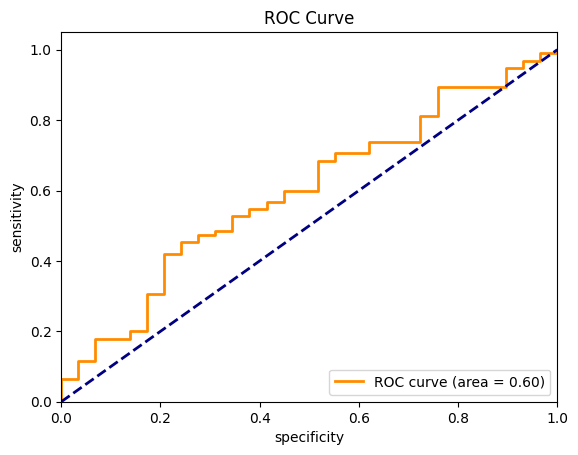

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc
from skimage import color, exposure, filters, measure
from skimage.filters import threshold_otsu, sobel, gaussian,threshold_isodata
import os
import matplotlib.pyplot as plt

# Load images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

# Feature extraction function
def feature_extractor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    enhanced_img = exposure.equalize_hist(gray)
    smoothed_img = gaussian(enhanced_img, sigma=1)
    smoothed_img = (smoothed_img * 255).astype(np.uint8)
    median_image = cv2.medianBlur(smoothed_img,5)

    edges = cv2.Canny(median_image, 100, 200)
    num_edges = np.count_nonzero(edges)
    return num_edges

# Classify images based on feature and threshold
def classify_images(images, labels, feature_extractor, threshold=130000):
    predictions = []
    for image in images:
        feature = feature_extractor(image)
        prediction = 1 if feature > threshold else 0
        predictions.append(prediction)
    return predictions

# Create ROC curve
def create_roc_curve(images, labels, feature_extractor):
    # Extract features
    features = [feature_extractor(image) for image in images]

    # Generate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, features)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('specificity')
    plt.ylabel('sensitivity')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage
image_folder = '/content/drive/MyDrive/CONTAINERS1/leafDataset'
images = load_images_from_folder(image_folder)


labels =  [1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,
           1,1,1,0,1,0,1, 1,1,1,1,1,0,0,1,1,1,1, 0,1,1,1,1,1, 0,0,0,1,1,1,1,1,0,0, 0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,0,1]

# Create ROC curve
create_roc_curve(images, labels, feature_extractor)
